# Preperation

## Directory and imports

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Courses/yearE/ML/ML_2021_quantum_control

Mounted at /gdrive
/gdrive/MyDrive/Courses/yearE/ML/ML_2021_quantum_control


In [2]:
!pip install qutip

     |████████████████████████████████| 14.6 MB 10 kB/s 


In [3]:
%load_ext autoreload
%autoreload 2

# Training

## Imports

In [4]:
from DataLoader import GamesMemoryBank
from policy_loss import PolicyLoss
from Model import PolicyNetwork
from simulation import QuantumEnvironment 

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

## Initialization

### Constants

In [5]:
n_epochs = 100
games_per_epoch = 10
batch_size = 24000
num_batches = 5
learning_rate = 1e-3

### Classes

In [6]:
env = QuantumEnvironment(energy_gap=1, runtime=15, dt=0.01, skips=1)

loss_func = PolicyLoss()
net = PolicyNetwork()

model_name = 'trained_model.pt'
# If such a previous model exists
net.load_state_dict(torch.load(model_name))

loss_func = PolicyLoss()
memory_bank = GamesMemoryBank()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## Training loop

In [ ]:
final_fidelity = []


for epoch in tqdm(range(n_epochs)):
    
    memory_bank.clear_memory()
    
    net.eval()
    net.cpu()
    
    for game_i in range(games_per_epoch):

        state, prev_state = env.reset(), None

        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        prev_state = state

        points_in_game = 0

        while True:
            with torch.no_grad():
                action, action_p = net.sample_action(state)
            new_state, reward, done, info = env.step(action + 2)
            memory_bank.add_event(state, action, action_p, reward)
            
            prev_state = state
            state = torch.tensor(new_state, dtype=torch.float).view(-1).unsqueeze(0)

            if done:
                final_fidelity.append(env.fidelity())
                break
    
    
    memory_bank.compute_reward_history()
    
    clear_output(wait=True)
    mean_fid = np.mean(final_fidelity[-games_per_epoch:])
    mean_fid = str(mean_fid)[:5]
    plt.title('epoch ' + str(epoch) 
                       + ' mean points last ' 
                       + str(games_per_epoch) 
                       + ' simulations '
                       + mean_fid)
    plt.plot(final_fidelity)
    plt.ylabel('Fidelity')
    plt.show()
    

    net.train()
    
    for batch_i in range(num_batches):
        optimizer.zero_grad()

        state, action, action_p, reward, discounted_reward = memory_bank.get_sample(batch_size)
        state = state.view((state.shape[0], 7))
        
        logits = net(state)

        loss = loss_func(logits, action, action_p, discounted_reward)
        loss.backward()
        optimizer.step()
    
    torch.save(net.state_dict(), model_name)

  0%|          | 0/100 [00:00<?, ?it/s]/gdrive/MyDrive/Courses/yearE/ML/ML_2021_quantum_control/simulation.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  return [float(x[0][0][0]), float(y[0][0][0]), float(z[0][0][0])]


In [ ]:
state, prev_state = env.reset(), None

state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
prev_state = state

points_in_game = 0

z = list()
omega = list()

while True:
    action, action_p = net.sample_action(state)
    new_state, reward, done, info = env.step(action + 2)
    state = torch.tensor(new_state, dtype=torch.float).view(-1).unsqueeze(0)
    z.append(state[0][-1])
    omega.append(state[0][3])
    if done:
      break

/gdrive/MyDrive/Courses/yearE/ML/ML_2021_quantum_control/simulation.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return [float(x[0][0][0]), float(y[0][0][0]), float(z[0][0][0])]


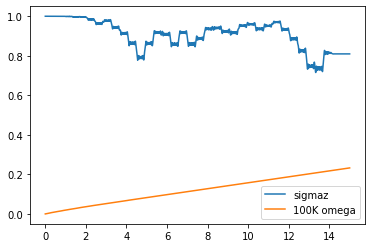

In [ ]:
T = np.linspace(0, 15, 1500)

plt.plot(T, z, label="sigmaz")
plt.plot(T, np.array(omega)/100000, label="100K omega")
plt.legend()
plt.show()

In [ ]:
import numpy as np

In [ ]:
A = np.array([1,2,3,4,5,6])
B = np.array([[1],[2],[3],[4],[5],[6]])

In [ ]:
A.shape

(6,)

In [ ]:
B.shape

(6, 1)